In [4]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sp
import cv2
from itertools import product
import json


from resnet_model.data_loading import *
from resnet_model.helpers_run_resnet import *

import torchvision.transforms as transforms

In [116]:
# import opencv
import cv2
import numpy as np


imput_dir = '/Volumes/T7 Shield/AntProject/magenta_ants/head/'
image_paths = read_image_file_names('/Volumes/T7 Shield/AntProject/magenta_ants/head/')

output_dir = '/Volumes/T7 Shield/AntProject/cropped_ants/head/'


In [117]:
for image_path in image_paths:
    input_dir_image = imput_dir + image_path
    input_image = cv2.imread(input_dir_image, cv2.IMREAD_UNCHANGED)

    height = input_image.shape[0]
    width = input_image.shape[1]

    # Checking image is grayscale or not. If image shape is 2 then gray scale otherwise not
    if len(input_image.shape) == 2:
        gray_input_image = input_image.copy()
    else:
        # Converting BGR image to grayscale image
        gray_input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    upper_threshold, thresh_input_image = cv2.threshold(
        gray_input_image, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    # Calculate lower threshold
    lower_threshold = 0.5 * upper_threshold

    # Apply canny edge detection
    canny = cv2.Canny(input_image, lower_threshold, upper_threshold)
    # Finding the non-zero points of canny
    pts = np.argwhere(canny > 0)

    # Finding the min and max points
    y1, x1 = pts.min(axis=0)
    y2, x2 = pts.max(axis=0)

    # Crop ROI from the givn image
    output_image = input_image[y1:y2, x1:x2]

    output_dir_image = output_dir + image_path

    cv2.imwrite(output_dir_image, output_image)

In [56]:
path_df = '/Users/lisavind/ml-project-2-kalamariunionen/colour_ants.csv'
images_dir = '/Volumes/T7 Shield/AntProject/original'

df = pd.read_csv(path_df)
df.head()

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,...,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance,file_head,file_thorax,file_abdomen
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,...,82,37,16,91,52,21,15.64,casent0280684_p_1_head.png,casent0280684_p_1_thorax.png,casent0280684_p_1_abdomen.png
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,...,118,74,37,166,129,77,26.18,casent0914659_p_1_head.png,casent0914659_p_1_thorax.png,casent0914659_p_1_abdomen.png
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,...,203,149,75,206,164,88,30.90,usnment00445715_p_1_head.png,usnment00445715_p_1_thorax.png,usnment00445715_p_1_abdomen.png
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,...,113,69,40,149,105,58,18.46,casent0178718_p_1_head.png,casent0178718_p_1_thorax.png,casent0178718_p_1_abdomen.png
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,...,107,68,29,110,68,28,17.92,casent0914660_p_1_head.png,casent0914660_p_1_thorax.png,casent0914660_p_1_abdomen.png


In [57]:
def open_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    return data

In [58]:
path_df = '/Volumes/T7 Shield/AntProject/colour_ants.csv'
images_dir = '/Volumes/T7 Shield/AntProject/original'

### Looking at preformance of baseline resnet model vs resnet model
Plotting training and validation loss for baseline resnet model and the performance for the resnet with an additional layer. This model has been hypertuned and the performance during hypertuning is plotted.

In [59]:
def read_sort_json_file_names(folder_path_run):
    file_paths = []
    for file_name in os.listdir(folder_path_run):
        if file_name.endswith(".json"):  # Only process JSON files
            file_path = os.path.join(folder_path_run, file_name)
            file_paths.append(str(file_path))

    sorted_file_paths = sorted(file_paths)

    return sorted_file_paths

In [14]:
folder_path_run = '/Users/lisavind/ml-project-2-kalamariunionen/resnet_model/runs_cluster_result'
sorted_file_paths = read_sort_json_file_names(folder_path_run)

folder_path_run_baseline = '/Users/lisavind/ml-project-2-kalamariunionen/resnet_model/runs_cluster_result/baseline'
baseline_file_path = read_sort_json_file_names(folder_path_run_baseline)

In [17]:
def get_loss(sorted_file_paths):
    val_loss = []
    for file_path in sorted_file_paths: 
        with open(file_path, "r") as file:
            data_dict = json.load(file)

            validation_loss = [entry[2] for entry in data_dict]

            val_loss.append(validation_loss)
    
    return val_loss

In [18]:
val_loss = get_loss(sorted_file_paths)

val_loss_baseline = get_loss(baseline_file_path)

In [19]:
hparam_space = {
            "batch_size": [512,256],
            "lr": [0.001, 0.0001],
            "nodes": [128, 256, 512]
        }

# Generate combinations of hyperparameters
keys, values = zip(*hparam_space.items())
hparam_combinations = [dict(zip(keys, v)) for v in product(*values)]

In [20]:
results_val = {}
#Tuning hyperparameters
for i,hparams in enumerate(hparam_combinations):
    # Extract hyperparameters for this iteration
    batch_size = hparams["batch_size"]
    learning_rate = hparams["lr"]
    nodes = hparams["nodes"]

    # Store the results using a tuple key
    results_val[(learning_rate, batch_size, nodes)] = val_loss[i]

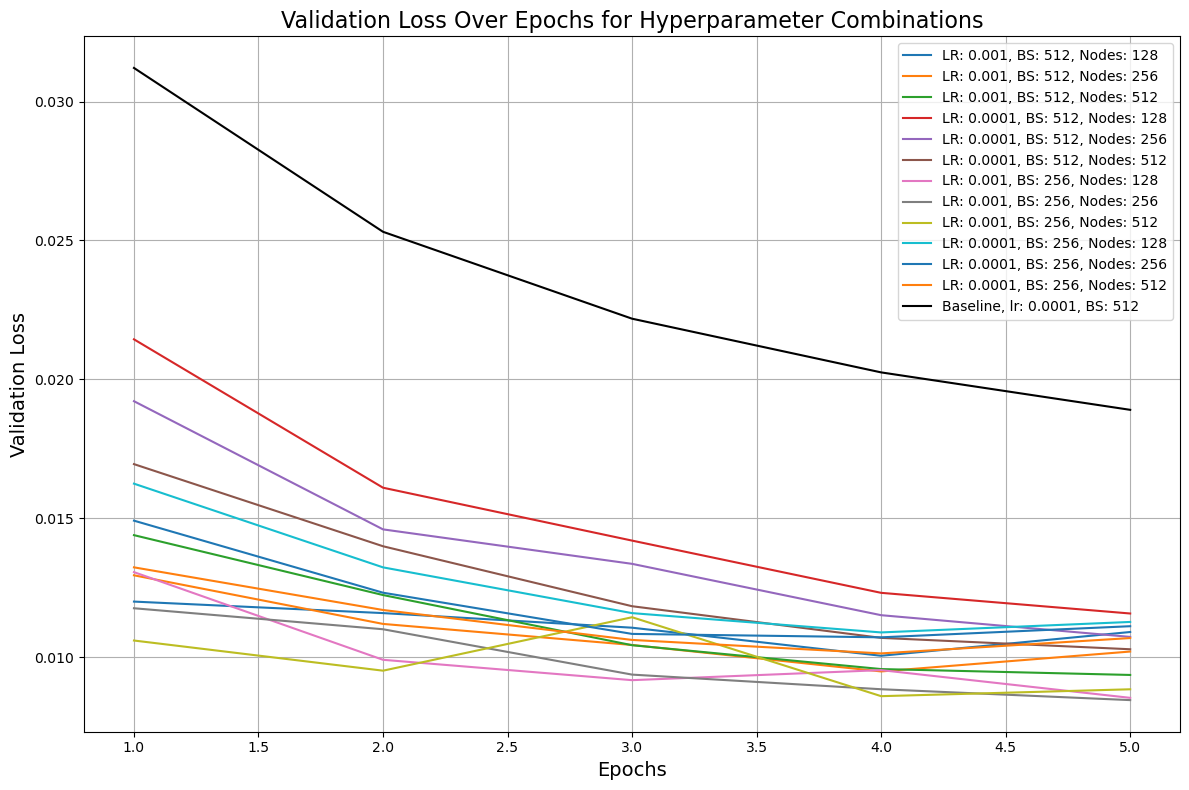

In [21]:
plt.figure(figsize=(12, 8))

for (lr, batch_size, nodes), losses in results_val.items():
    epochs = range(1, len(losses) + 1)  
    label = f"LR: {lr}, BS: {batch_size}, Nodes: {nodes}"
    plt.plot(epochs, losses, label=label)

plt.plot(epochs,val_loss_baseline[0], color='black', label='Baseline, lr: 0.0001, BS: 512')

# Add labels, legend, and title
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Validation Loss", fontsize=14)
plt.title("Validation Loss Over Epochs for Hyperparameter Combinations", fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Loading in best preforming model and evaluating it further

In [22]:
#Reading in best preforming model target and output colors
file_path_target = "resnet_model/output_training/run_2024-12-11_10-16-35/target_colors/target_colors_model1.pkl"
target_colors = open_pickle(file_path_target)

file_path_output = "resnet_model/output_training/run_2024-12-11_10-16-35/output_colors/output_colors_model1.pkl"
output_colors = open_pickle(file_path_output)

In [23]:
def convert(tensors):
    return [t.numpy() for t in tensors] 

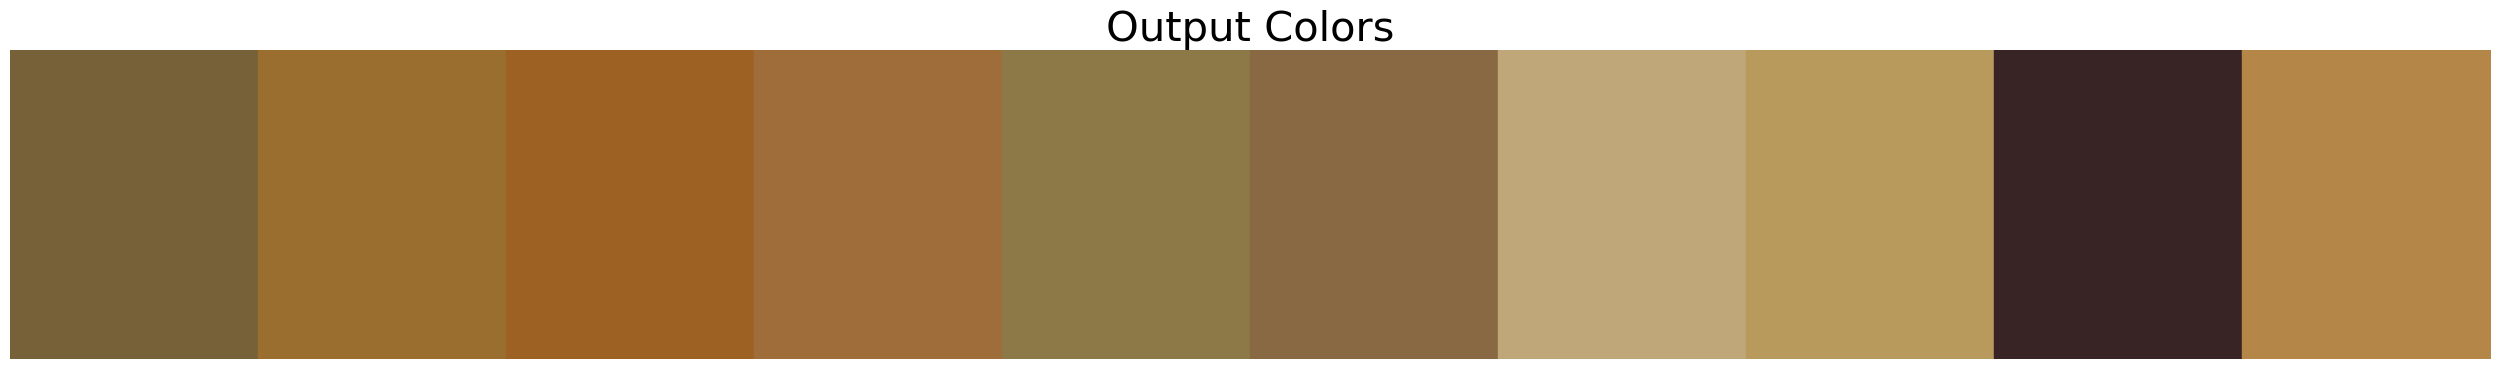

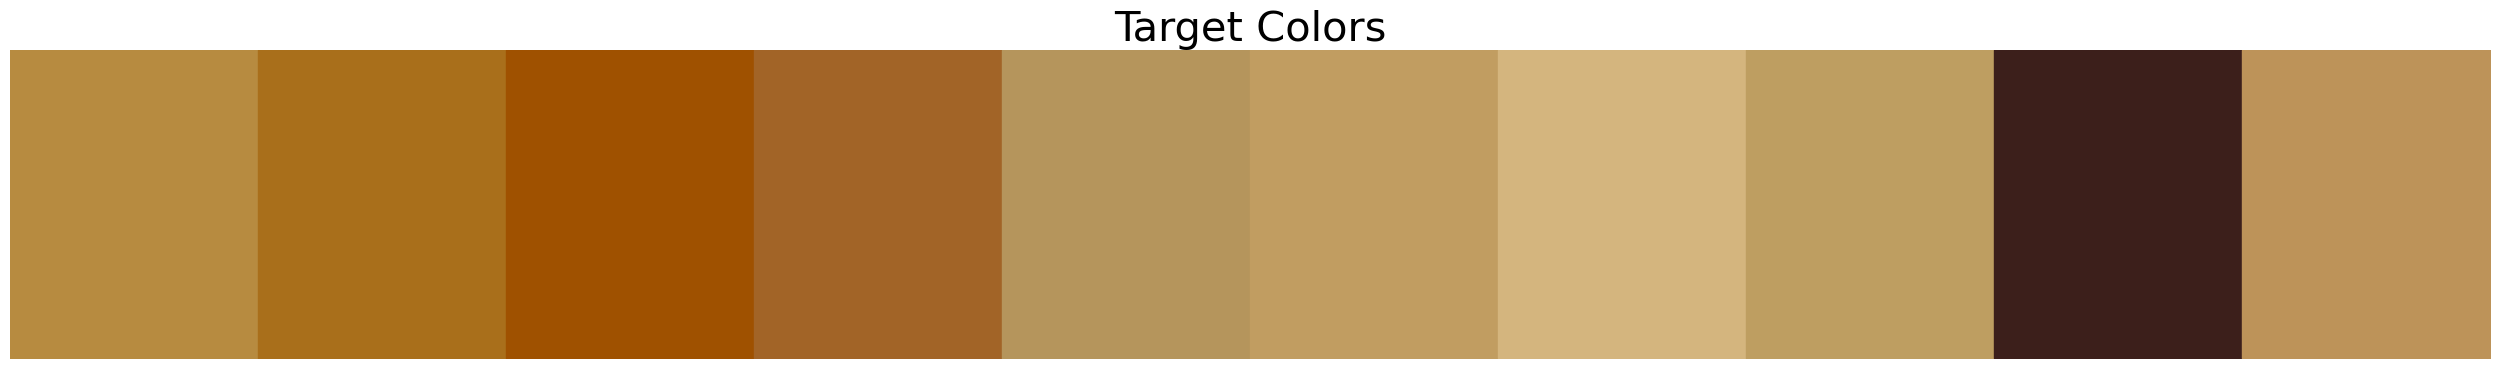

In [24]:
def plot_rgb_blocks(color_list, title, max_colors=None):
    if max_colors is not None:
        color_list = color_list[:max_colors]  # Slice the list to include only the specified number of colors

    plt.figure(figsize=(max(32, len(color_list)), 4))  # Adjust figure width dynamically
    for i, color in enumerate(color_list):
        color_rgb = np.clip(color, 0, 1)  # Ensure values are between 0 and 1
        plt.fill_between([i, i + 1], 0, 1, color=color_rgb)
        
    plt.xlim(0, len(color_list))
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

# Plot output and target color
plot_rgb_blocks(convert(output_colors[0]), "Output Colors",max_colors = 10)
plot_rgb_blocks(convert(target_colors[0]), "Target Colors",max_colors = 10)

In [26]:
df_rgb = get_bodypart_rgb_values(df, 'thorax')

specimen_set = set(df['specimen'])  # Convert to a set for faster lookup

image_file_names = read_image_file_names(images_dir)

image_file_set = set(image_file_names)

# Filter the DataFrame by checking if 'original_file' is in image_file_set
filtered_df = df_rgb[df_rgb['original_file'].isin(image_file_set)]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_ratio = 0.8
val_ratio = 0.1
val_dataset = ImageLabelDataset(images_dir,filtered_df,train_ratio,val_ratio,transform, split='val')


File is empty: /Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg


In [27]:
print(len(val_dataset))

2876


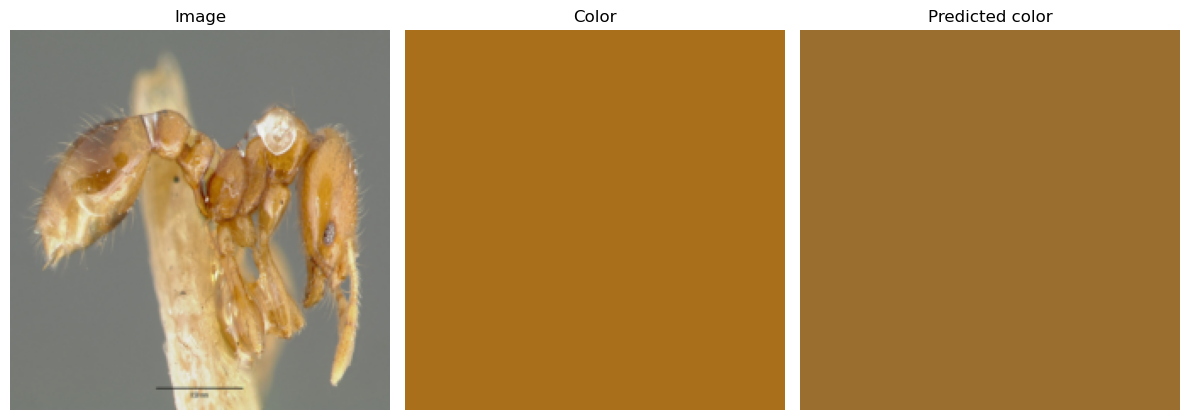

In [46]:
output_colors_np = convert(output_colors[0])

for i, (img, label) in enumerate(val_dataset):

    if i > 0:
        index = i #- 511
        # Convert tensors to numpy arrays for visualization
        img_np = img.permute(1, 2, 0).numpy()

        label = label.numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis("off")

        rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(label)
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[index]
        
        ax[1].imshow(rgb_image)
        ax[1].set_title("Color")
        ax[1].axis("off")

        ax[2].imshow(rgb_target)
        ax[2].set_title("Predicted color")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

        if i == 1:
            break

Try runing model without standardizing the data!

### Plot evaluation matrics

In [29]:
def convert_values_to_numpy(output_tensor):
    output_np = []
    for batch in output_tensor:
        for value in batch:
            output_np.append(value.numpy())

    return np.array(output_np)

In [82]:
target_colors_np = convert_values_to_numpy(target_colors)
output_colors_np = convert_values_to_numpy(output_colors)

#se = np.sum((target_colors_np - output_colors_np), axis = 1) ** 2
euclidian_distance = np.sum((target_colors_np - output_colors_np)** 2, axis = 1)
mean_euclidian_distance = np.sum((target_colors_np- output_colors_np)**2, axis = 1)/3
test = np.mean(mean_euclidian_distance)

print(test)


0.008522528


In [83]:
print(len(val_dataset))
print(len(target_colors_np))

2876
2876


In [84]:
from torch import nn
criterion = nn.MSELoss()

loss = 0 
for i in range(0,len(target_colors)):
    loss += criterion(target_colors[i], output_colors[i])

print(loss/len(target_colors))

tensor(0.0084)


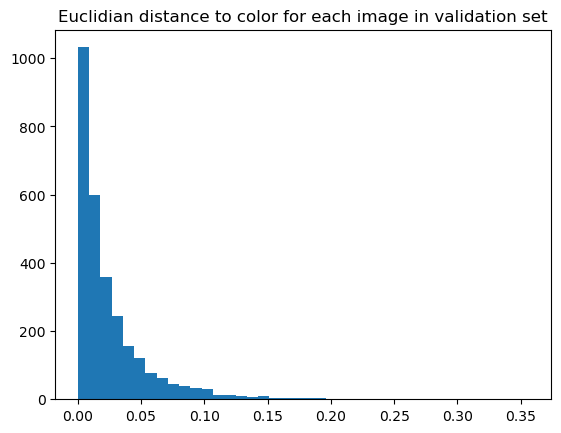

In [85]:
plt.hist(euclidian_distance, bins = 40)
#plt.yscale('log')
plt.title('Euclidian distance to color for each image in validation set')
plt.show()

In [35]:
#Mean square error per color channel
ed_sorted_index = np.argsort(euclidian_distance)
ed_sorted = np.sort(euclidian_distance)

In [36]:
print(len(euclidian_distance))

2876


In [37]:
lowest_10_indices = ed_sorted_index[:10]
highest_10_indices = ed_sorted_index[-10:]

In [38]:
def plot_colors_with_subplots(target_colors_np, output_colors_np, indices):
    # Initialize arrays for all target and output color rows
    all_target_colors = []
    all_output_colors = []

    for idx in indices:
        # Create a single row of 10x10 blocks for the target and output colors
        target_block = np.ones((10, 10, 3), dtype=float) * target_colors_np[idx]
        output_block = np.ones((10, 10, 3), dtype=float) * output_colors_np[idx]

        # Append the block to respective lists
        all_target_colors.append(target_block)
        all_output_colors.append(output_block)

    # Combine all blocks for each row into horizontal arrays
    target_row = np.hstack(all_target_colors)  # Horizontal stack for targets
    output_row = np.hstack(all_output_colors)  # Horizontal stack for outputs

    # Create the figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(len(indices), 4))
    # Plot target colors in the first subplot
    axs[0].imshow(target_row)
    axs[0].axis("off")
    axs[0].set_title("Target Colors")
    # Plot output colors in the second subplot
    axs[1].imshow(output_row)
    axs[1].axis("off")
    axs[1].set_title("Output Colors")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()




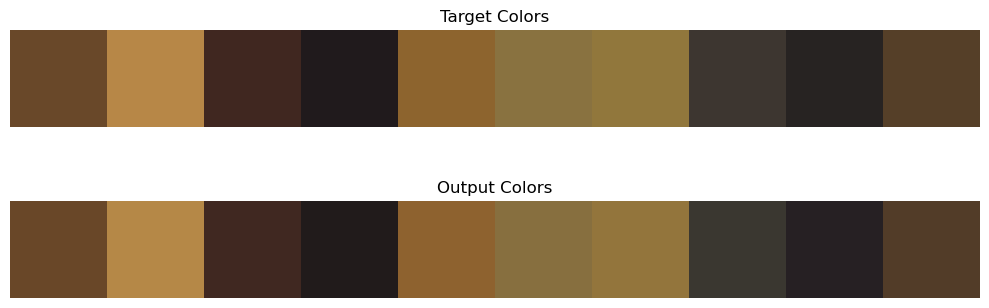

In [39]:
plot_colors_with_subplots(target_colors_np, output_colors_np, lowest_10_indices)

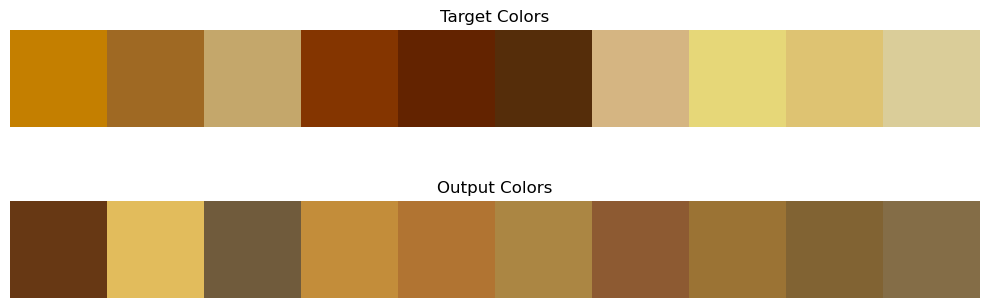

In [40]:
plot_colors_with_subplots(target_colors_np, output_colors_np, highest_10_indices)

### Read segment resnet model

In [61]:
df.head()

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,...,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance,file_head,file_thorax,file_abdomen
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,...,82,37,16,91,52,21,15.64,casent0280684_p_1_head.png,casent0280684_p_1_thorax.png,casent0280684_p_1_abdomen.png
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,...,118,74,37,166,129,77,26.18,casent0914659_p_1_head.png,casent0914659_p_1_thorax.png,casent0914659_p_1_abdomen.png
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,...,203,149,75,206,164,88,30.90,usnment00445715_p_1_head.png,usnment00445715_p_1_thorax.png,usnment00445715_p_1_abdomen.png
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,...,113,69,40,149,105,58,18.46,casent0178718_p_1_head.png,casent0178718_p_1_thorax.png,casent0178718_p_1_abdomen.png
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,...,107,68,29,110,68,28,17.92,casent0914660_p_1_head.png,casent0914660_p_1_thorax.png,casent0914660_p_1_abdomen.png


In [51]:
#Reading in best preforming model target and output colors

#head
file_path_target = "/Users/lisavind/ml-project-2-kalamariunionen/resnet_model/output_training/run_2024-12-16_16-33-27/target_colors/target_colors_baseline.pkl"
target_colors_head = open_pickle(file_path_target)

file_path_output = "/Users/lisavind/ml-project-2-kalamariunionen/resnet_model/output_training/run_2024-12-16_16-33-27/output_colors/output_colors_baseline.pkl"
output_colors_head = open_pickle(file_path_output)

In [62]:
images_dir_head = '/Volumes/T7 Shield/AntProject/magenta_ants/head'

In [71]:
df_rgb_head = get_bodypart_rgb_values(df, 'head', column_name = 'file_head')

In [72]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_ratio = 0.8
val_ratio = 0.1
val_dataset_head = ImageLabelDataset(images_dir_head,df_rgb_head,train_ratio,val_ratio,transform, split='val')

File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0913901_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0913909_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/focol1875_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0908812_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0913925_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0902354_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0636200_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/focol0641-4_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/inbiocri002728554_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0604312_p_1_head.png
File not found: /Volumes/T7 Shield/AntProject/magenta_ants/head/casent0900944_p_1_head.png
F

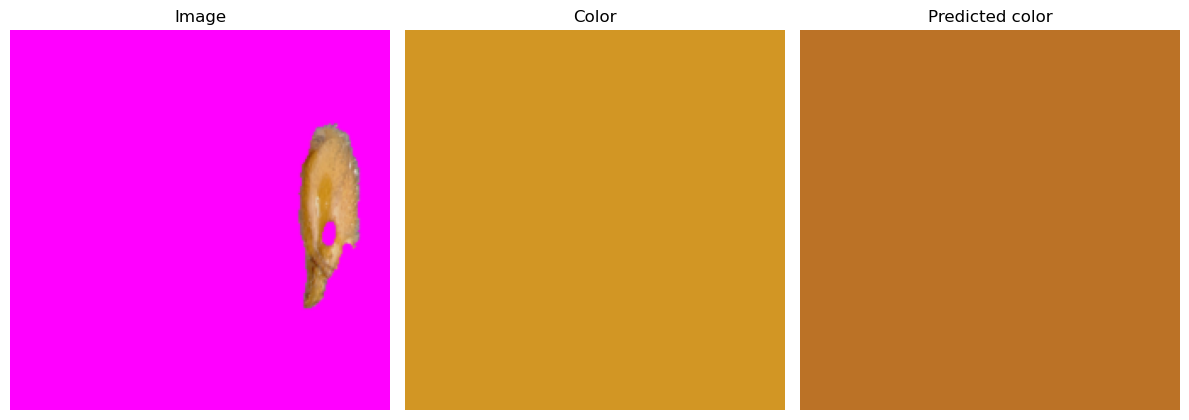

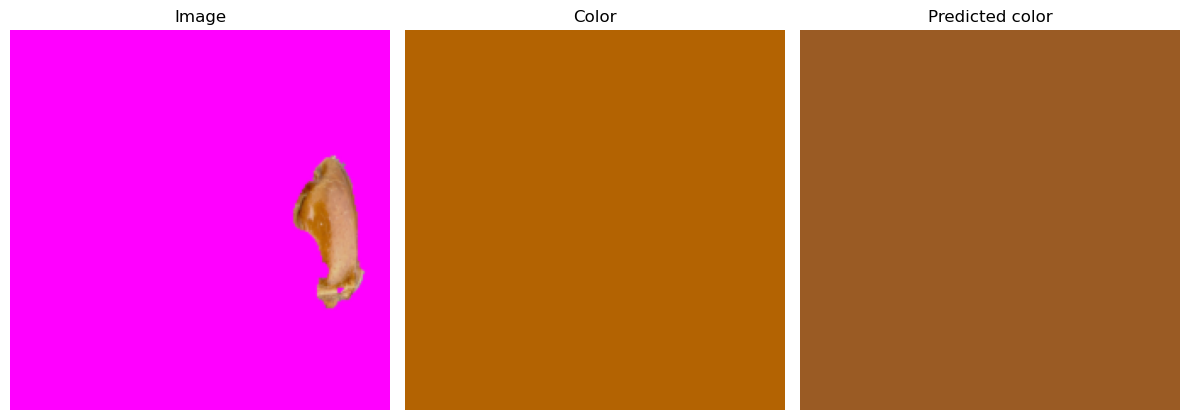

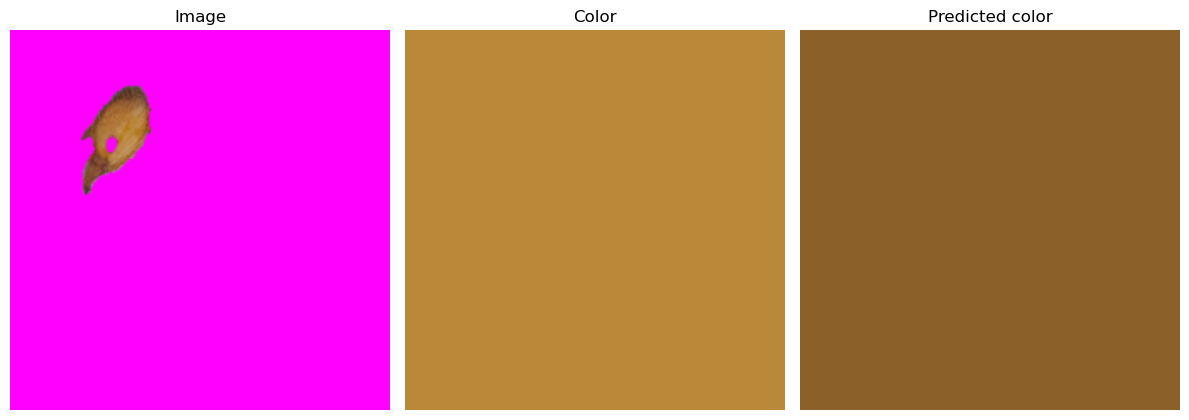

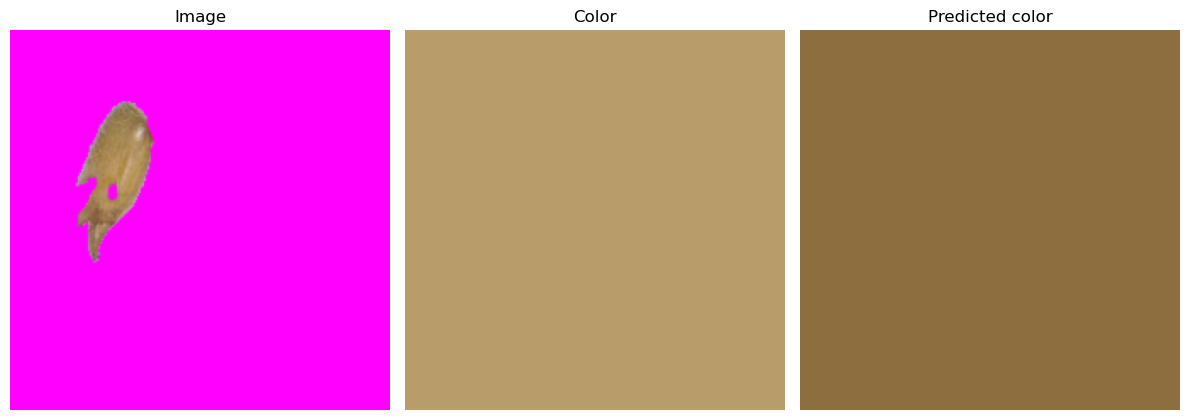

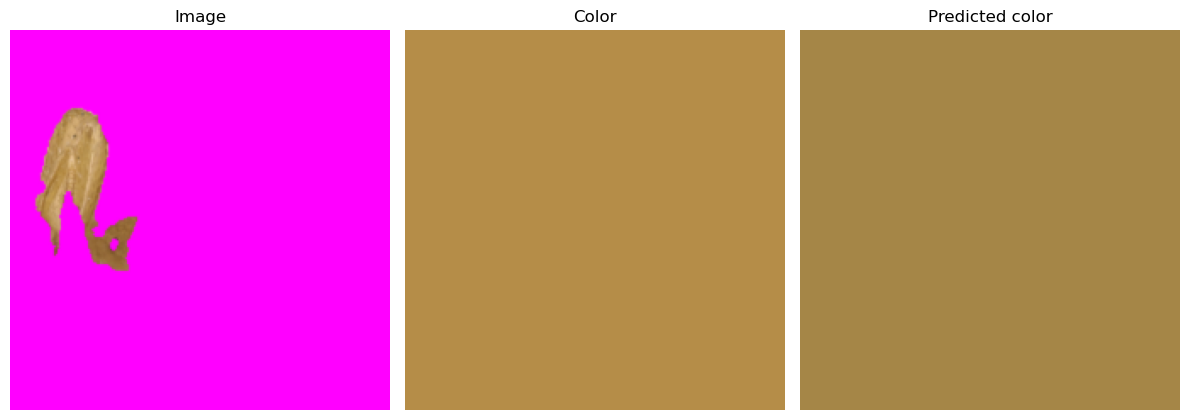

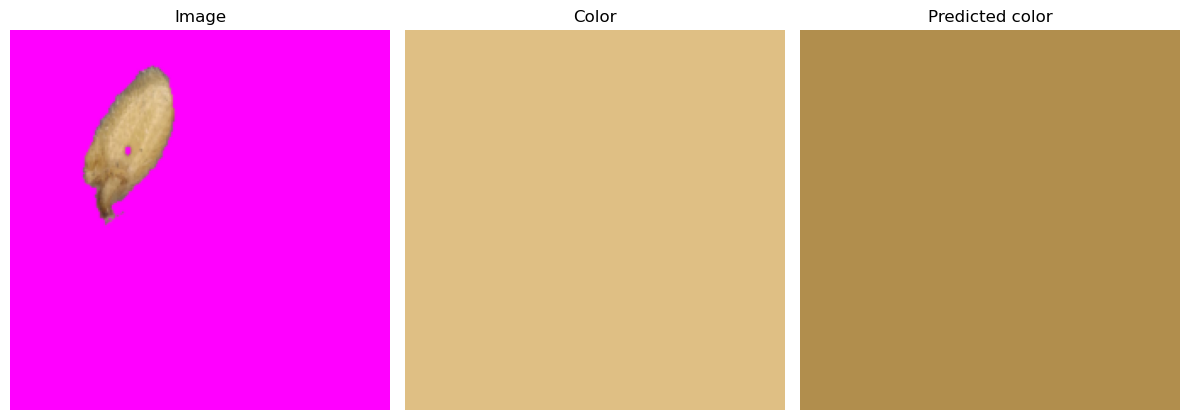

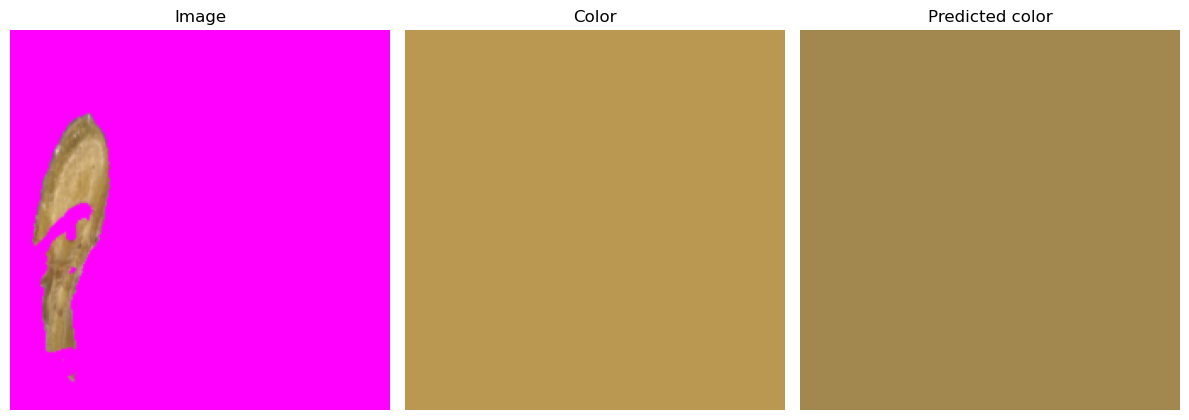

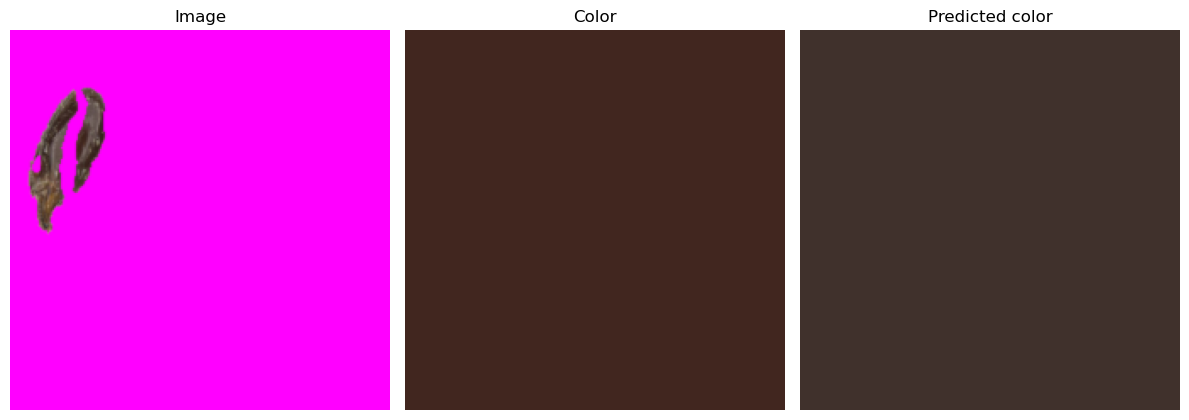

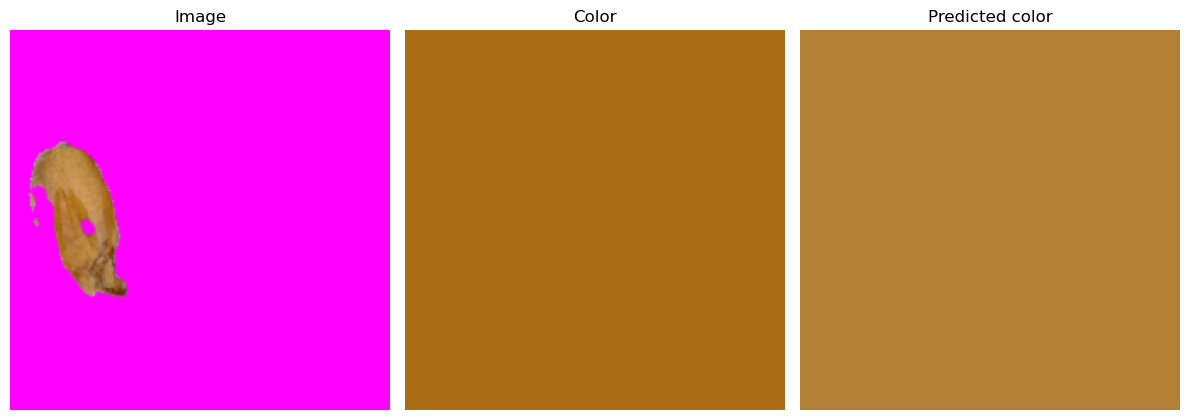

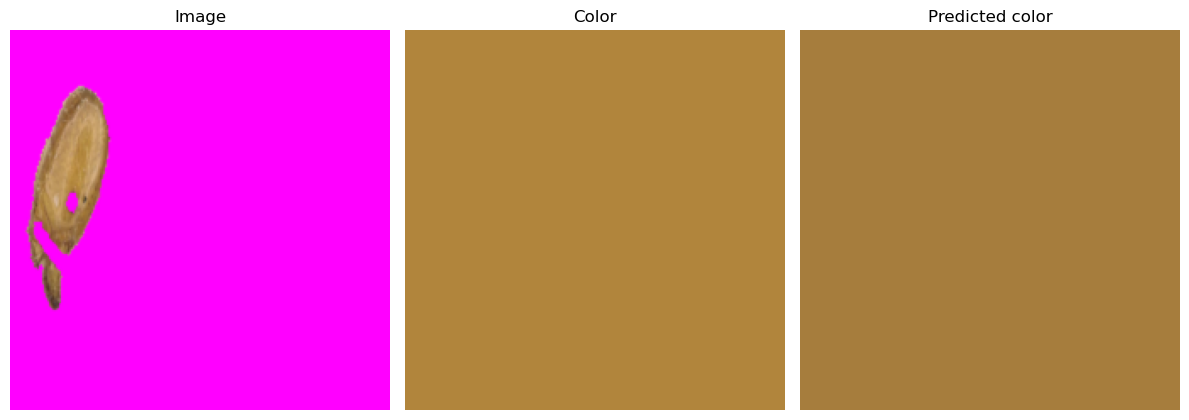

In [96]:
output_colors_head_np = convert(output_colors_head[0])

for i, (img, label) in enumerate(val_dataset_head):

    if i > 0:
        index = i #- 511
        # Convert tensors to numpy arrays for visualization
        img_np = img.permute(1, 2, 0).numpy()

        label = label.numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis("off")

        rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(label)
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_head_np[index]
        
        ax[1].imshow(rgb_image)
        ax[1].set_title("Color")
        ax[1].axis("off")

        ax[2].imshow(rgb_target)
        ax[2].set_title("Predicted color")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

        if i == 10:
            break

### Looking at preformance

In [86]:
target_colors_head_np = convert_values_to_numpy(target_colors_head)
output_colors_head_np = convert_values_to_numpy(output_colors_head)

In [87]:
euclidian_distance_head = np.sum((target_colors_head_np - output_colors_head_np)** 2, axis = 1)

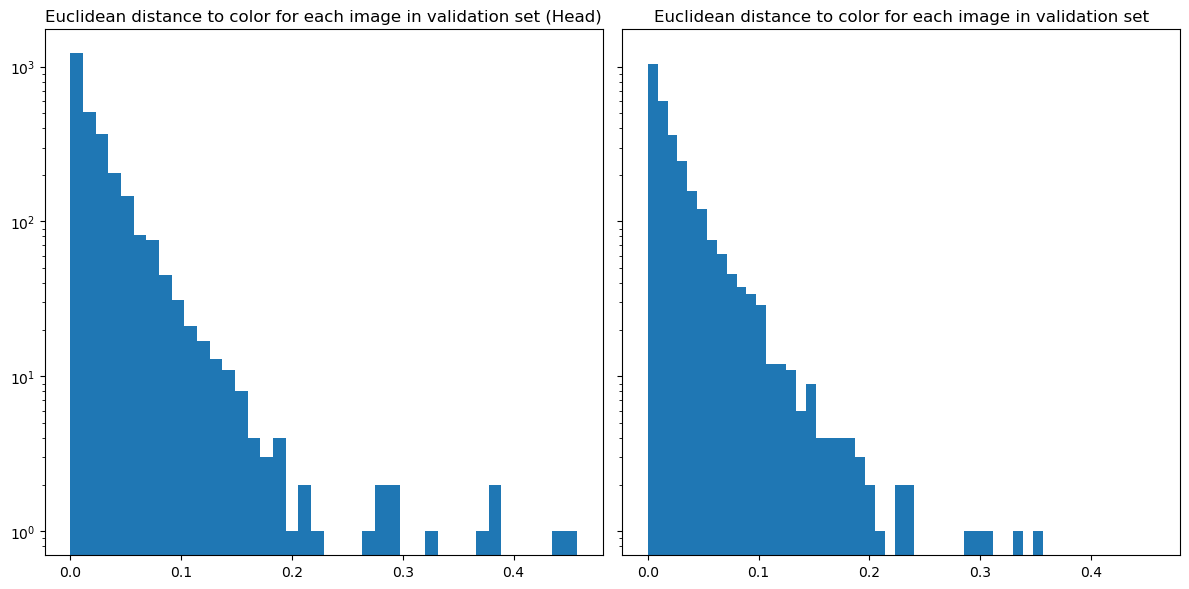

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)  
axs[0].hist(euclidian_distance_head, bins=40)
axs[0].set_title('Euclidean distance to color for each image in validation set (Head)')
axs[0].set_yscale('log')

axs[1].hist(euclidian_distance, bins=40)
axs[1].set_title('Euclidean distance to color for each image in validation set')
axs[1].set_yscale('log')


plt.tight_layout()
plt.show()

In [92]:
criterion = nn.MSELoss()

loss_head = 0 
for i in range(0,len(target_colors_head)):
    loss_head += criterion(target_colors_head[i], output_colors_head[i])

print(loss_head/len(target_colors))

tensor(0.0081)


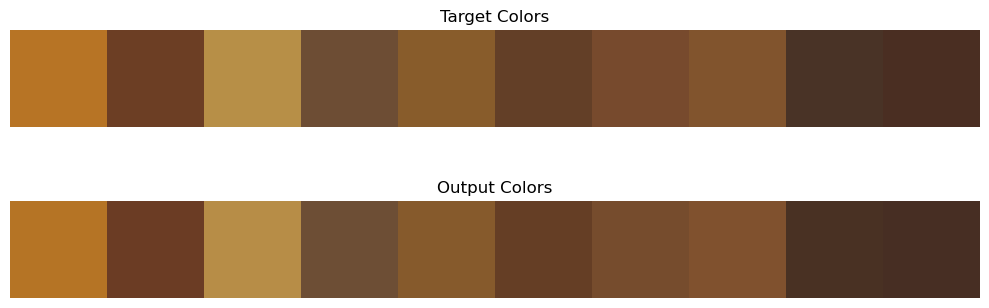

In [93]:
ed_sorted_index_head = np.argsort(euclidian_distance_head)
ed_sorted_head  = np.sort(euclidian_distance_head)
lowest_10_indices_head = ed_sorted_index_head [:10]
highest_10_indices_head = ed_sorted_index_head [-10:]
plot_colors_with_subplots(target_colors_head_np, output_colors_head_np, lowest_10_indices_head)

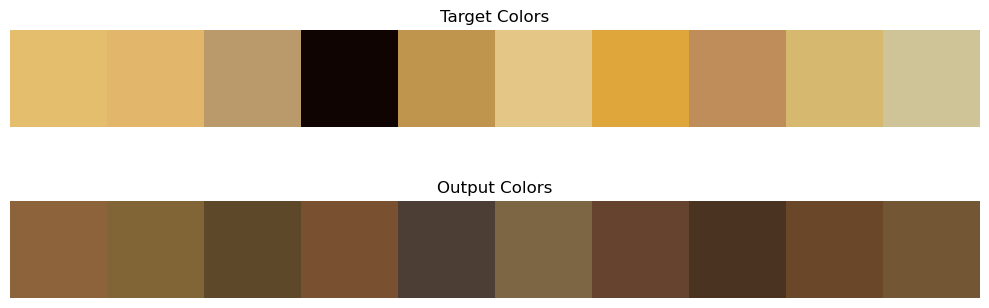

In [94]:
plot_colors_with_subplots(target_colors_head_np, output_colors_head_np, highest_10_indices_head)

In [97]:
highest_10_indices_head

array([2040, 2068, 2410,  725, 1117, 2139, 1032, 2603, 2041, 2288])

### Experiment finding reference pixel

In [197]:
def plot_colors(target_colors_np,output_colors_np, index):

    for i in range(0,len(index)):
        fig, ax = plt.subplots(1, 2, figsize=(2, 2))
        rgb_image = np.ones((10, 10, 3), dtype=int) * target_colors_np[index[i]]
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[index[i]]

        ax[0].imshow(rgb_image)
        ax[0].set_title("Color")
        ax[0].axis("off")

        ax[1].imshow(rgb_target)
        ax[1].set_title("Predicted color")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

In [198]:
target_colors_np

array([[0.7176471 , 0.54509807, 0.2509804 ],
       [0.6627451 , 0.43529412, 0.10588235],
       [0.62352943, 0.31764707, 0.        ],
       ...,
       [0.33333334, 0.24705882, 0.15686275],
       [0.5176471 , 0.34901962, 0.21176471],
       [0.52156866, 0.34509805, 0.23137255]], dtype=float32)

### Plot colors

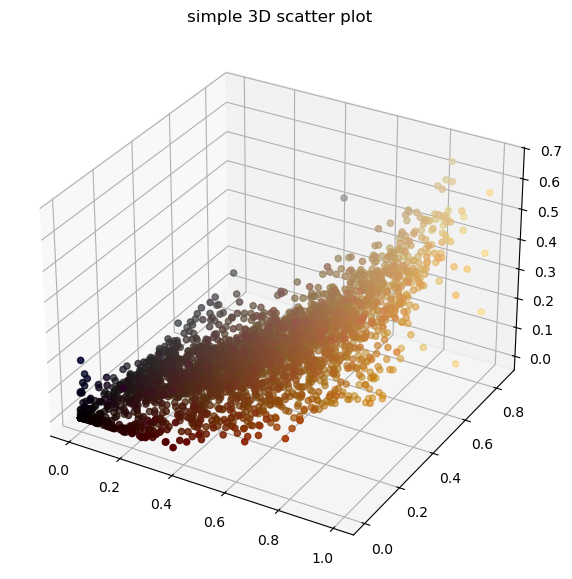

In [68]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2]))

# Creating plot
ax.scatter3D(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [69]:
output_colors_np

out_of_bounds = (output_colors_np < 0) | (output_colors_np > 1)

if np.any(out_of_bounds):
    print("Some values are out of bounds. Clipping them to the range [0, 1].")
    output_colors_np = np.clip(output_colors_np, 0, 1)
else:
    print("All values are within the range [0, 1].")


All values are within the range [0, 1].


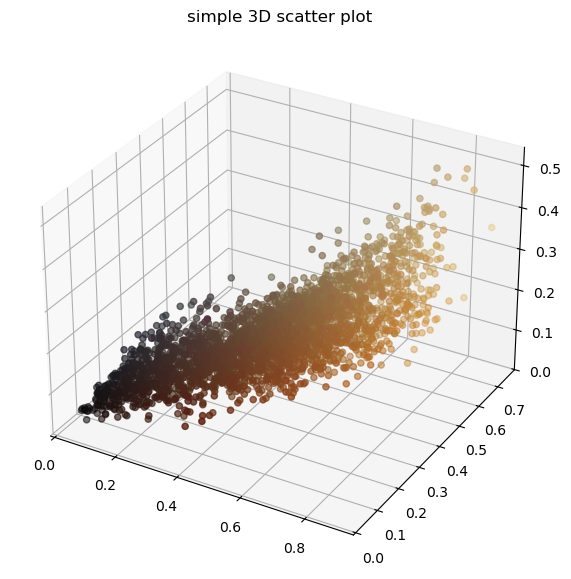

In [70]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2]))

# Creating plot
ax.scatter3D(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

I feel like the prediction looks "linear". Maybe add another layer. The fully connected layer can only produce inear functions??

### Trying to find the represatentative pixel:

In [71]:
def find_representative_pixel(image, rgb_target, rgb_output):
    min_distance_target = 0.00005
    min_distance_output = 0.00005

    min_target_px = []
    min_target_py = []
    min_output_px = []
    min_output_py = []

    for py in range(0,223):
        for px in range(0,223):
            image_color = (image[py][px][0],image[py][px][1],image[py][px][2])
            distance_target = np.mean((image_color - rgb_target)**2)
            distance_output = np.mean((image_color - rgb_output)**2)

            if distance_target < min_distance_target:
                #min_distance_target = distance_target
                min_target_px.append(px)
                min_target_py.append(py)
            
            if distance_output < min_distance_output:
                #min_distance_output = distance_output
                min_output_px.append(px)
                min_output_py.append(py)

    return min_target_px,min_target_py,min_distance_target,min_output_px,min_output_py, min_distance_output

In [72]:
index = 20

for i, (img, label) in enumerate(val_dataset):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))

    if i == index:
        break

In [73]:
image.shape

(224, 224, 3)

In [74]:
min_target_px,min_target_py,min_distance_target,min_output_px,min_output_py, min_distance_output = find_representative_pixel(image, target_colors_np[index], output_colors_np[index])

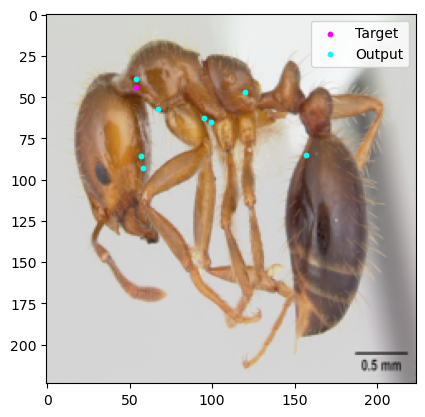

In [75]:
plt.imshow(image)

# Mark the target pixel with magenta
plt.scatter(min_target_px, min_target_py, color='magenta', label='Target', s=10)

# Mark the output pixel with cyan
plt.scatter(min_output_px, min_output_py, color='cyan', label='Output', s=10)

# Adding legend for clarity
plt.legend()